<a href="https://colab.research.google.com/github/Untick/NetOptik/blob/main/Lytkin%20Vladimir/Netoptic_vgg16_VL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Загрузка библиотек


In [1]:
# Работа с массивами
import numpy as np

# Генератор аугментированных изображений
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Основа для создания последовательной модели
from tensorflow.keras.models import Sequential

# Основные слои
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization

# Оптимизатор
from tensorflow.keras.optimizers import Adam

# Матрица ошибок классификатора
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Подключение модуля для загрузки данных из облака
import gdown

# Инструменты для работы с файлами
import os

# Генерация случайных чисел
import random

#Библиотеки для отрисовки
from PIL import Image
import matplotlib.pyplot as plt

# Рисование графиков в ячейках Colab
%matplotlib inline

### Задание гиперпараметров модели

In [2]:
# Задание гиперпараметров

TRAIN_PATH          = '/content/frames/'       # Папка для обучающего набора данных
TEST_PATH           = '/content/frames_test/'  # Папка для тестового набора данных

TEST_SPLIT          = 0.1                     # Доля тестовых данных в общем наборе
VAL_SPLIT           = 0.2                    # Доля проверочной выборки в обучающем наборе

IMG_WIDTH           = 256                   # Ширина изображения для нейросети
IMG_HEIGHT          = 512                    # Высота изображения для нейросети
IMG_CHANNELS        = 3                     # Количество каналов (для RGB равно 3, для Grey равно 1)

# Параметры аугментации
ROTATION_RANGE      = 8                     # Пределы поворота
WIDTH_SHIFT_RANGE   = 0.15                  # Пределы сдвига по горизонтали (float: fraction of total width, if < 1, or pixels if >= 1)
HEIGHT_SHIFT_RANGE  = 0.15                  # Пределы сдвига по вертикали   (float: fraction of total height, if < 1, or pixels if >= 1
ZOOM_RANGE          = 0.15                  # Пределы увеличения/уменьшения
# BRIGHTNESS_RANGE    = (0.7, 1.3)            # Пределы изменения яркости
HORIZONTAL_FLIP     = True                  # Горизонтальное отражение разрешено

EPOCHS              = 30                    # Число эпох обучения
BATCH_SIZE          = 50                    # Размер батча для обучения модели (значительно влияет на обучение, 40 лучше 25)
OPTIMIZER           = Adam(0.0001)         # Оптимизатор

FILE_BEST_WEIGHTS        = '/content/drive/MyDrive/data_stazhirovka1/material_best_model_w.h5'    # веса модели с лучщим val_accuracy
FILE_LAST_WEIGHTS        = '/content/drive/MyDrive/data_stazhirovka1/material_last_model_w.h5'    # веса модели после окончания обучения на всех эпохах

### Загрузка датасета с Google диска

In [3]:
# Монтирование GoogleDrive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Загрузка zip-архива с GoogleDrive на диск виртуальной машины Colab
gdown.download('https://drive.google.com/uc?id=1JyMoZOJBwTY2MI9oFFHt4Brf3Q_ULWk5', None, quiet=True)

'glass_material_no_combi.zip'

In [5]:
# Разархивация датасета в директорию 'content/frames'
# !unzip -qo "glass_material.zip" -d /content/frames
!unzip -qo "glass_material_no_combi.zip" -d /content/frames

In [6]:
# Проверка загрузки
os.listdir(TRAIN_PATH)

['Металл 418', 'Пластик 500']

### Подготовка данных

In [7]:
# Определение списка имен классов
CLASS_LIST = sorted(os.listdir(TRAIN_PATH))

# Определение количества классов
CLASS_COUNT = len(CLASS_LIST)

# Проверка результата
print(f'Количество классов: {CLASS_COUNT}, метки классов: {CLASS_LIST}')

Количество классов: 2, метки классов: ['Металл 418', 'Пластик 500']


In [ ]:
# списки файлов для всех классов (проверка)
# for cls in CLASS_LIST:
#     print(cls, ':', os.listdir(f'{IMAGE_PATH}{cls}/'))

In [8]:
# Перенос файлов для теста в отдельное дерево папок, расчет размеров наборов данных

try:
  os.mkdir(TEST_PATH)                                        # Создание папки для тестовых данных
except:
  pass

train_count = 0
test_count = 0

for class_name in CLASS_LIST:                              # Для всех классов по порядку номеров (их меток)
    class_path = f'{TRAIN_PATH}{class_name}'              # Формирование полного пути к папке с изображениями класса
    test_path = f'{TEST_PATH}{class_name}'                # Полный путь для тестовых данных класса
    class_files = os.listdir(class_path)                   # Получение списка имен файлов с изображениями текущего класса
    class_file_count = len(class_files)                    # Получение общего числа файлов класса

    try:
      os.mkdir(test_path)                                    # Создание подпапки класса для тестовых данных
    except:
      pass

    test_file_count = int(class_file_count * TEST_SPLIT)   # Определение числа тестовых файлов для класса
    test_files = class_files[-test_file_count:]            # Выделение файлов для теста от конца списка
    for f in test_files:                                   # Перемещение тестовых файлов в папку для теста
        os.rename(f'{class_path}/{f}', f'{test_path}/{f}')
    train_count += class_file_count                        # Увеличение общего счетчика файлов обучающего набора
    test_count += test_file_count                          # Увеличение общего счетчика файлов тестового набора

    print(f'Размер класса {class_name}: {class_file_count} оправ, для теста выделено файлов: {test_file_count}')

print(f'Общий размер базы: {train_count}, выделено для обучения: {train_count - test_count}, для теста: {test_count}')

Размер класса Металл 418: 418 оправ, для теста выделено файлов: 41
Размер класса Пластик 500: 499 оправ, для теста выделено файлов: 49
Общий размер базы: 917, выделено для обучения: 827, для теста: 90


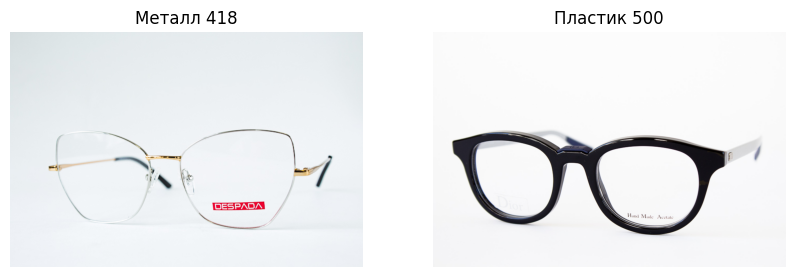

In [9]:
# Отрисовка по одному изображению, выбранному случайно, из каждого класса обучающей выборки
fig, axs = plt.subplots(1, CLASS_COUNT, figsize=(10, 5))

# Для всех номеров классов:
for i in range(CLASS_COUNT):
    # Формирование пути к папке содержимого класса
    frame_path = f'{TRAIN_PATH}{CLASS_LIST[i]}/'
    # Выбор случайного фото из i-го класса
    img_path = frame_path + random.choice(os.listdir(frame_path))
    # Отображение фотографии
    axs[i].set_title(CLASS_LIST[i])
    axs[i].imshow(Image.open(img_path))
    axs[i].axis('off')

# Отрисовка всего полотна
plt.show()

### Генераторы изображений и выборок

In [10]:
# Генераторы изображений

# Изображения для обучающего набора нормализуются и аугментируются согласно заданным гиперпараметрам
# Далее набор будет разделен на обучающую и проверочную выборку в соотношении VAL_SPLIT
train_datagen = ImageDataGenerator(
                    rescale=1. / 255.,                      # Перескалирование значений пикселей изображений, чтобы они находились в диапазоне от 0 до 1
                    rotation_range=ROTATION_RANGE,          # случайные повороты в диапазоне [-RORATION_RANGE, ROTAION_RANGE] градусов
                    width_shift_range=WIDTH_SHIFT_RANGE,    # случайное горизонтальное смещение в диапазоне [-WIDTH_SHIFT_RANGE, WIDTH_SHIFT_RANGE] пикселей
                    height_shift_range=HEIGHT_SHIFT_RANGE,  # случайное вертикальное смещение в диапазоне [-HEIGHT_SHIFT_RANGE, HEIGHT_SHIFT_RANGE] пикселей
                    zoom_range=ZOOM_RANGE,                  # случайное масштабирование в диапазоне ZOOM_RANGE в процентах (0.2=20%)
                    horizontal_flip=HORIZONTAL_FLIP,        # Случайное отражение изображений по горизонтали (True or False)
                    validation_split=VAL_SPLIT              # доля проверочной выборке от общего количества тренировочной выборки
                )

# Изображения для тестового набора только нормализуются
test_datagen = ImageDataGenerator(
                   rescale=1. / 255.
                )

In [11]:
# Обучающая выборка генерируется из папки обучающего набора
train_generator = train_datagen.flow_from_directory(
    # Путь к обучающим изображениям
    TRAIN_PATH,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    subset='training'
)

# Проверочная выборка также генерируется из папки обучающего набора
validation_generator = train_datagen.flow_from_directory(
    TRAIN_PATH,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    subset='validation'
)

# Тестовая выборка генерируется из папки тестового набора
test_generator = test_datagen.flow_from_directory(
    TEST_PATH,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=test_count,
    class_mode='categorical',
    shuffle=True,
)

Found 662 images belonging to 2 classes.
Found 165 images belonging to 2 classes.
Found 90 images belonging to 2 classes.


In [12]:
# Проверка формы данных
print(f'Формы данных тренировочной выборки: {train_generator[0][0].shape}, {train_generator[0][1].shape}, батчей: {len(train_generator)}')
print(f'Формы данных   проверочной выборки: {validation_generator[0][0].shape}, {validation_generator[0][1].shape}, батчей: {len(validation_generator)}')
print(f'Формы данных      тестовой выборки: {test_generator[0][0].shape}, {test_generator[0][1].shape}, батчей: {len(test_generator)}')

print()

# Проверка назначения меток классов
print(f'Метки классов тренировочной выборки: {train_generator.class_indices}')
print(f'Метки классов   проверочной выборки: {validation_generator.class_indices}')
print(f'Метки классов      тестовой выборки: {test_generator.class_indices}')

Формы данных тренировочной выборки: (50, 256, 512, 3), (50, 2), батчей: 14
Формы данных   проверочной выборки: (50, 256, 512, 3), (50, 2), батчей: 4
Формы данных      тестовой выборки: (90, 256, 512, 3), (90, 2), батчей: 1

Метки классов тренировочной выборки: {'Металл 418': 0, 'Пластик 500': 1}
Метки классов   проверочной выборки: {'Металл 418': 0, 'Пластик 500': 1}
Метки классов      тестовой выборки: {'Металл 418': 0, 'Пластик 500': 1}


In [13]:
# Функция рисования образцов изображений из заданной выборки

def show_batch(batch,                # батч с примерами
               img_range=range(25),  # диапазон номеров картинок
               figsize=(12, 4),      # размер полотна для рисования одной строки таблицы
               columns=5             # число колонок в таблице
               ):

    for i in img_range:
        ix = i % columns
        if ix == 0:
            fig, ax = plt.subplots(1, columns, figsize=figsize)
        class_label = np.argmax(batch[1][i])
        ax[ix].set_title(CLASS_LIST[class_label])
        ax[ix].imshow(batch[0][i])
        ax[ix].axis('off')
        plt.tight_layout()

    plt.show()

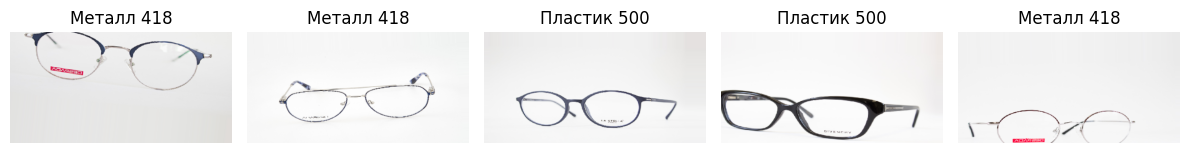

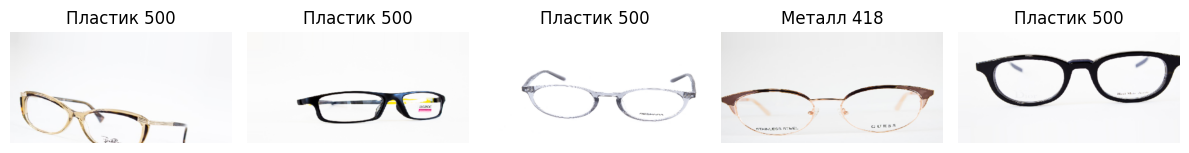

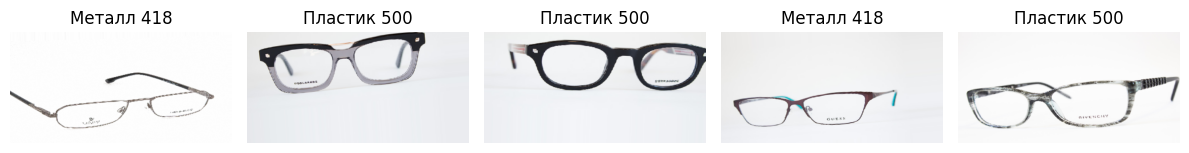

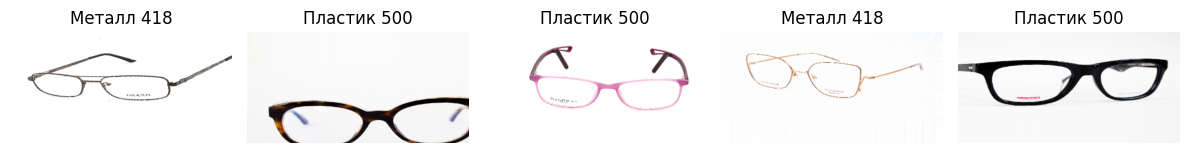

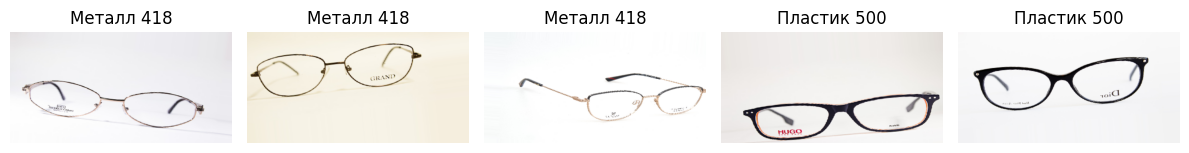

In [14]:
# Вывод примеров из 0-го батча train_generator
show_batch(train_generator[0])

### Создание нейронной сети на основе предобученной VGG16

In [15]:
# Библиотеки предобученной сети VGG16
from keras.applications import VGG16

# Загружаем предварительно обученную нейронную сеть
model_vgg16_trained = VGG16(weights='imagenet',                         # признаки из набора данных "ImageNet"
                            include_top=False,                          # отключаем часть "классификация", оставляем только "сверточную часть"
                            input_shape=(IMG_WIDTH, IMG_HEIGHT, 3))     # размер тензора входных изображений

# "Замораживаем" веса предварительно обученной нейронной сети VGG16 (сверточную часть обучать не будем)
model_vgg16_trained.trainable = False
model_vgg16_trained.summary()


58889256/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 512, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 512, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 512, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 256, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 256, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 256, 128)     147584    
                                                              

In [16]:
# Создаем свою составную сеть на основе предобученной VGG16

model = Sequential()
# Добавляем в модель сеть VGG16 вместо слоя
model.add(model_vgg16_trained)
# Блок классификации
model.add(Flatten(name='Class_1'))
model.add(Dense(256, activation='relu', name='Class_2'))
model.add(Dropout(0.3))
model.add(Dense(CLASS_COUNT, activation='softmax', name='Class_3'))


In [17]:
# Архитектура созданной сети
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 8, 512)         14714688  
                                                                 
 Class_1 (Flatten)           (None, 16384)             0         
                                                                 
 Class_2 (Dense)             (None, 256)               4194560   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 Class_3 (Dense)             (None, 2)                 514       
                                                                 
Total params: 18,909,762
Trainable params: 4,195,074
Non-trainable params: 14,714,688
_________________________________________________________________


### Компиляция и обучение модели с сохранением лучших весов в файле FILE_BEST_WEIGHTS

In [17]:
# Функция компиляции и обучения модели нейронной сети с сохранением лучших весов на GoogleDrive
# По окончанию выводит графики обучения
from tensorflow.keras.callbacks import ModelCheckpoint

def compile_train_model(model,                  # модель нейронной сети
                        train_data,             # обучающие данные
                        val_data,               # проверочные данные
                        optimizer=OPTIMIZER,    # оптимизатор
                        epochs=EPOCHS,          # количество эпох обучения
                        batch_size=BATCH_SIZE,  # размер батча
                        figsize=(20, 5)):       # размер полотна для графиков

    # Компиляция модели
    model.compile(
        loss='categorical_crossentropy',
        optimizer=optimizer,
        metrics=['accuracy'])

    # Обучение модели с заданными параметрами
    checkpoint_callback = ModelCheckpoint(filepath=FILE_BEST_WEIGHTS,
                                          save_weights_only=True,
                                          monitor='val_accuracy',
                                          save_best_only=True)
    history = model.fit(train_data,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=val_data,
                        callbacks=checkpoint_callback)                # лучший результат

    # Вывод графиков точности и ошибки
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    fig.suptitle('График процесса обучения модели')
    ax1.plot(history.history['accuracy'],
               label='Доля верных ответов на обучающем наборе')
    ax1.plot(history.history['val_accuracy'],
               label='Доля верных ответов на проверочном наборе')
    ax1.xaxis.get_major_locator().set_params(integer=True)
    ax1.set_xlabel('Эпоха обучения')
    ax1.set_ylabel('Доля верных ответов')
    ax1.legend()

    ax2.plot(history.history['loss'],
               label='Ошибка на обучающем наборе')
    ax2.plot(history.history['val_loss'],
               label='Ошибка на проверочном наборе')
    ax2.xaxis.get_major_locator().set_params(integer=True)
    ax2.set_xlabel('Эпоха обучения')
    ax2.set_ylabel('Ошибка')
    ax2.legend()
    plt.show()

Epoch 1/30
14/14 [==============================] - 77s 4s/step - loss: 1.0545 - accuracy: 0.5770 - val_loss: 0.4835 - val_accuracy: 0.7576
Epoch 2/30
14/14 [==============================] - 44s 3s/step - loss: 0.3153 - accuracy: 0.8640 - val_loss: 0.2336 - val_accuracy: 0.9394
Epoch 3/30
14/14 [==============================] - 43s 3s/step - loss: 0.1521 - accuracy: 0.9547 - val_loss: 0.1904 - val_accuracy: 0.9515
Epoch 4/30
14/14 [==============================] - 42s 3s/step - loss: 0.1103 - accuracy: 0.9773 - val_loss: 0.2240 - val_accuracy: 0.8909
Epoch 5/30
14/14 [==============================] - 42s 3s/step - loss: 0.1050 - accuracy: 0.9683 - val_loss: 0.2371 - val_accuracy: 0.8970
Epoch 6/30
14/14 [==============================] - 42s 3s/step - loss: 0.0737 - accuracy: 0.9789 - val_loss: 0.1955 - val_accuracy: 0.9091
Epoch 7/30
14/14 [==============================] - 43s 3s/step - loss: 0.0893 - accuracy: 0.9668 - val_loss: 0.1934 - val_accuracy: 0.9091
Epoch 8/30
14/14 [==

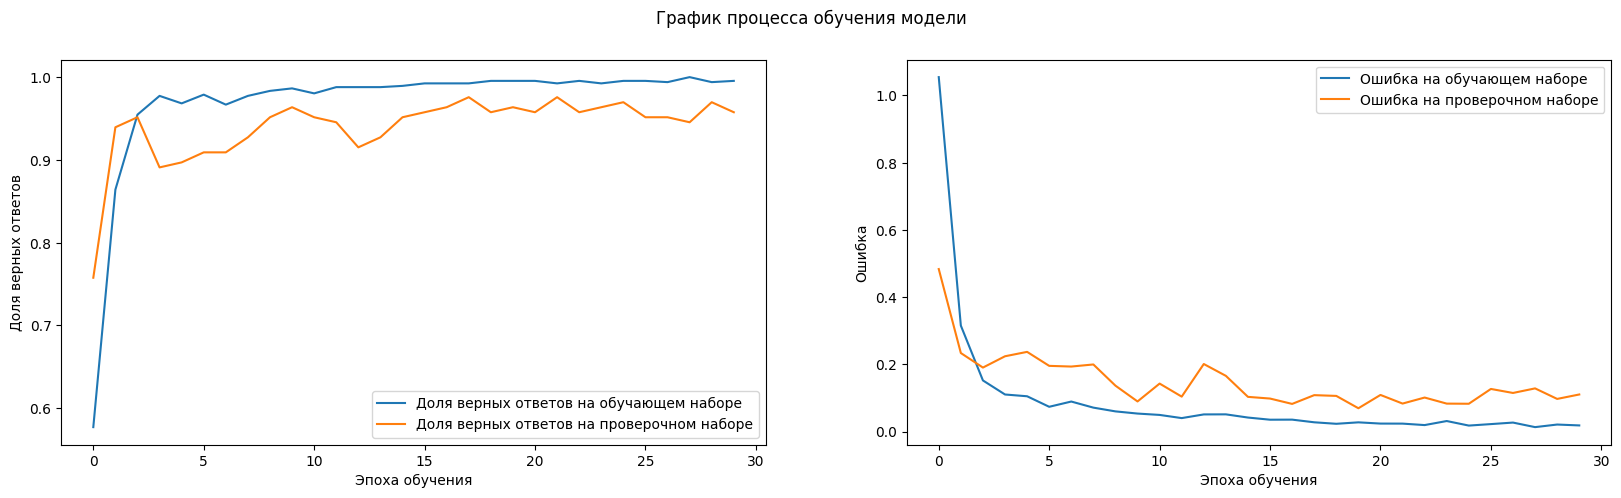

In [18]:
# Компиляция и обучение модели на заданных параметрах
compile_train_model(model,
                    train_generator,
                    validation_generator)

In [21]:
# Сохранение весов после окончания всех эпох в файл
model.save_weights(FILE_LAST_WEIGHTS)

### Загрузка сохраненных лучших или последних весов из каталога GoogleDrive

In [26]:
# Загрузка сохраненных лучших весов из GoogleDrive
model.load_weights(FILE_BEST_WEIGHTS)

In [24]:
# Загрузка сохраненных последних весов из GoogleDrive
model.load_weights(FILE_LAST_WEIGHTS)

### Проверка на тестовом наборе: отрисовка матрицы ошибок

In [19]:
# Функция вывода результатов оценки модели на заданных данных

def eval_model(model,
               x,                # данные для предсказания модели (вход)
               y_true,           # верные метки классов в формате OHE (выход)
               class_labels=[],  # список меток классов
               cm_round=3,       # число знаков после запятой для матрицы ошибок
               title='',         # название модели
               figsize=(10, 10)  # размер полотна для матрицы ошибок
               ):
    # Вычисление предсказания сети
    y_pred = model.predict(x)
    # Построение матрицы ошибок
    cm = confusion_matrix(np.argmax(y_true, axis=1),
                          np.argmax(y_pred, axis=1),
                          normalize='true')
    # Округление значений матрицы ошибок
    cm = np.around(cm, cm_round)

    # Отрисовка матрицы ошибок
    fig, ax = plt.subplots(figsize=figsize)
    ax.set_title(f'Нейросеть {title}: матрица ошибок нормализованная', fontsize=18)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    disp.plot(ax=ax)
    ax.images[-1].colorbar.remove()       # Стирание ненужной цветовой шкалы
    fig.autofmt_xdate(rotation=45)        # Наклон меток горизонтальной оси
    plt.xlabel('Предсказанные классы', fontsize=16)
    plt.ylabel('Верные классы', fontsize=16)
    plt.show()

    print('-'*100)
    print(f'Нейросеть: {title}')

    # Для каждого класса:
    for cls in range(len(class_labels)):
        # Определяется индекс класса с максимальным значением предсказания (уверенности)
        cls_pred = np.argmax(cm[cls])
        # Формируется сообщение о верности или неверности предсказания
        msg = 'ВЕРНО :-)' if cls_pred == cls else 'НЕВЕРНО :-('
        # Выводится текстовая информация о предсказанном классе и значении уверенности
        print('Класс: {:<20} {:3.0f}% сеть отнесла к классу {:<20} - {}'.format(class_labels[cls],
                                                                               100. * cm[cls, cls_pred],
                                                                               class_labels[cls_pred],
                                                                               msg))

    # Средняя точность распознавания определяется как среднее диагональных элементов матрицы ошибок
    print('\nСредняя точность распознавания: {:3.0f}%'.format(100. * cm.diagonal().mean()))



3/3 [==============================] - 1s 327ms/step


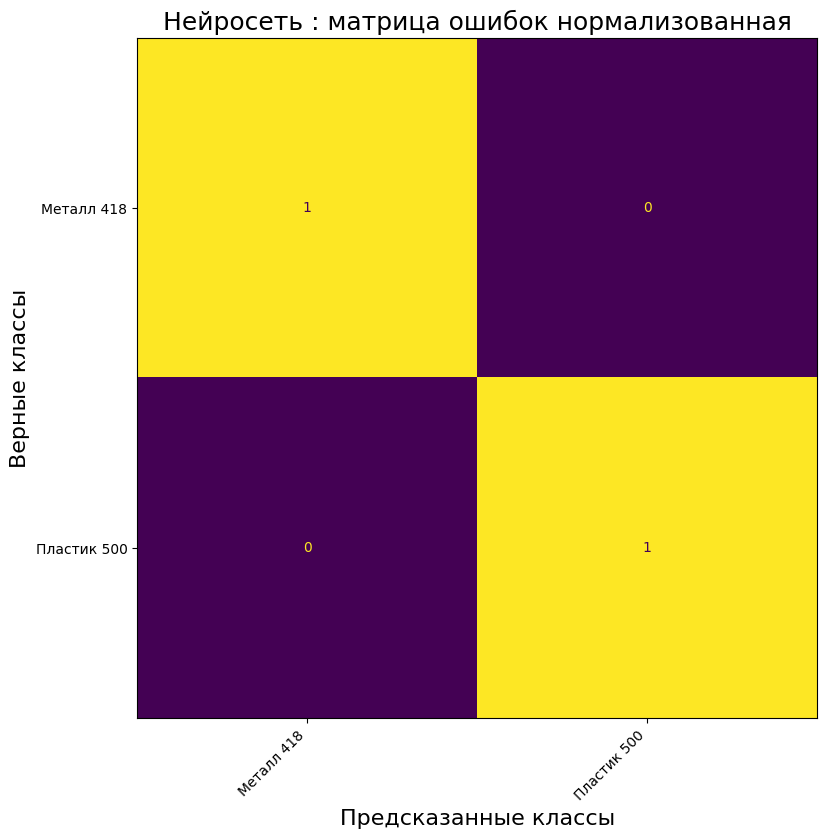

----------------------------------------------------------------------------------------------------
Нейросеть: 
Класс: Металл 418           100% сеть отнесла к классу Металл 418           - ВЕРНО :-)
Класс: Пластик 500          100% сеть отнесла к классу Пластик 500          - ВЕРНО :-)

Средняя точность распознавания: 100%


In [27]:
# Отрисовка матрицы ошибок
eval_model(model, test_generator[0][0], test_generator[0][1], class_labels=CLASS_LIST)